# House Prices - Advanced Regression Techniques
(Preços de casas - Técnicas Avançadas de Regressão)

<img src="https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png" width=800>


- Vamos utilizar o [dataset disponível no Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)
    - É um dataset de **competição**
    - Temos uma base com a **descrição de cada uma das colunas (data_description.txt)**
- **Etapas do Projeto:**
    - O projeto será realizado aplicando submissões no kaggle a medida que o tratamento dos dados forem tomando forma, isso possibilita verificar o desempenho dos modelos preditivos a modificações específicas neste tratamento.

**Utilizando os modelos na base tratada**

In [76]:
import pandas as pd

In [77]:
# Importando os datasets
base_train = pd.read_csv('train_2.csv')
base_test = pd.read_csv('test_2.csv')

## Submissões dos checkpoints
- Escolher modelos mais indicados para as bases dado o observado no tratamento
- Realizar seleção de features
- Otimizar hiperparâmetros dos modelos
- Submeter no Kaggle
- Comparar desempenhos de tratamentos e modelos

In [78]:
# Selecionar colunas numéricas
col_n = base_train.columns[base_train.dtypes != 'object']
col_n

Index(['OverallQual', 'GrLivArea', 'GarageArea/Car', 'YearBuilt', 'FullBath',
       'GarageYrBlt', 'AreaTotalBsmt', 'YearRemodAdd', 'TotRmsAbvGrd',
       'Fireplaces', 'OpenPorchSF', 'LotArea', 'MasVnrArea', 'LotFrontage',
       'WoodDeckSF', 'HalfBath', 'BsmtFinSF1', 'SalePrice'],
      dtype='object')

In [79]:
# Atribuindo essas colunas a nossa base
base_train = base_train.loc[:,col_n]

In [80]:
base_test = base_test.loc[:,col_n.drop('SalePrice')]

## Criando modelos

- **Vamos separar em treino e teste**
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [81]:
# Selecionando X e y
X = base_train.drop('SalePrice',axis=1)
y = base_train.SalePrice

In [82]:
# Importando o train_test_split
from sklearn.model_selection import train_test_split

In [83]:
# Separando essa base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Métrica de avaliação (RMSLE)
- Essa função será utilizada para seleção de features e como scoring do GridSearchCV
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxDZcRHy4lOtYjOjcxhn72vPMjBGjRnPxkKA&s" width=800>

In [84]:
# Definir função que calcula essa métrica
import numpy as np
from sklearn.metrics import make_scorer

# Função para calcular o RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))

## Seleção de algorítmos:
- Observamos que nossa base possui as seguintes características:
    - Poucos dados (linhas)
    - Muitas features
    - Aproximadamente a mesma quantidade de variáveis numéricas e categóricas
    - Correlação não linear features vs target
    - Distribuição um tanto assimétrica da target
### Selecionar 3 modelos para testar 
    - Gradient Booster (indicado na própria competição)
    - XGBoost Regressor (Variação do Gradiente boosting)
    - Lasso (Apesar de ser um modelo linear lida bem com alta dimensionalidade e poucos dados)

## Gradient Boosting

#### Determinar a importancia das features de acordo com o modelo 

In [85]:
# Importar o algorítmo
from sklearn.ensemble import GradientBoostingRegressor
# Setar o random state para todos os modelos, isso possibilita tirar a aleatoriedade e sempre obter os mesmos valores
random_state = 0
# Chamar o modelo
GB = GradientBoostingRegressor(random_state=0)
# Fit do modelo
GB.fit(X_train, y_train)
# Extrair importâncias das features de acordo com o modelo
importances = GB.feature_importances_
# Ordenar de forma decrescente as features com melhor importancia
feature_importance_GB = pd.Series(abs(importances), index=X_train.columns).sort_values(ascending=False)
print(feature_importance_GB)

OverallQual       0.511439
GrLivArea         0.154484
AreaTotalBsmt     0.073603
GarageArea/Car    0.060761
BsmtFinSF1        0.052841
YearBuilt         0.035564
LotArea           0.025207
YearRemodAdd      0.022317
Fireplaces        0.013399
LotFrontage       0.011185
MasVnrArea        0.008288
TotRmsAbvGrd      0.008072
GarageYrBlt       0.007268
WoodDeckSF        0.006867
OpenPorchSF       0.004238
HalfBath          0.003823
FullBath          0.000647
dtype: float64


### Utilizar o modelo em ordem crescente de features com a maior importancia e observar melhor desempenho

In [86]:
from sklearn.metrics import mean_squared_error

performance_GB = []

# Observar quantidade ideal de dimenssão neste modelo (maldição da dimensionalidade)

for i in range(1, len(X_train.columns)+1):  
    X_train_selected = X_train.loc[:,feature_importance_GB.index[:i]]
    X_test_selected = X_test.loc[:,feature_importance_GB.index[:i]]
    
    GB = GradientBoostingRegressor(random_state=0)
    GB.fit(X_train_selected, y_train)
    
    y_pred = GB.predict(X_test_selected)
    
    performance_GB.append(rmsle(y_test, y_pred))
    
performance_GB

[0.22968195305513636,
 0.2113581682522095,
 0.18940974603934943,
 0.17843366592625132,
 0.17087527885581175,
 0.16298788639825235,
 0.16055600029783607,
 0.15585132425393566,
 0.15642468382267294,
 0.15943116780333716,
 0.16121436139046766,
 0.159098641774488,
 0.16093979377554185,
 0.16079038832965384,
 0.1577727988319676,
 0.15621039273407258,
 0.15634823119228053]

### RMSLE em função da quantidade de features

<Figure size 2400x1600 with 0 Axes>

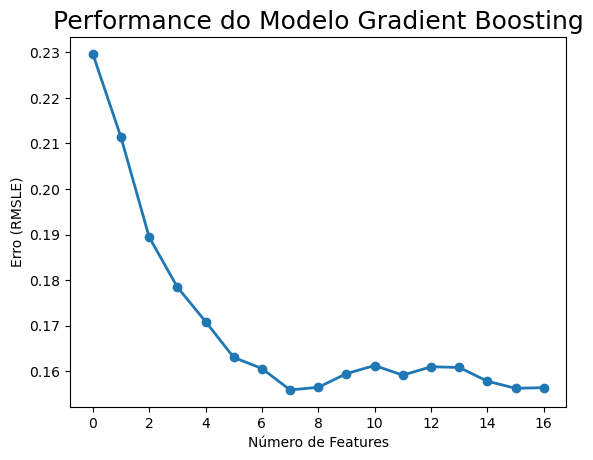

In [87]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(24, 16))
# plot
fig, ax = plt.subplots()

ax.plot(range(len(performance_GB)), performance_GB, linewidth=2.0, marker='o')

ax.set_title('Performance do Modelo Gradient Boosting', fontsize=18)
ax.set_xlabel('Número de Features', fontsize=10)
ax.set_ylabel('Erro (RMSLE)', fontsize=10)

plt.show()

In [88]:
# Valore ideal de features
performance_GB.index(min(performance_GB))

7

In [117]:
# Treinando com a quantidade ideal de features
GB = GradientBoostingRegressor(random_state=0)
GB.fit(X_train.loc[:,feature_importance_GB.index[:performance_GB.index(min(performance_GB))+1]], y_train)

y_pred_gb = GB.predict(X_test.loc[:,feature_importance_GB.index[:performance_GB.index(min(performance_GB))+1]])

RMSLE_GB = rmsle(y_test, y_pred_gb)
RMSLE_GB

0.15585132425393566

## XGBoost

In [90]:
import xgboost as xgb
#Criando modelo e fazendo o fit
XG = xgb.XGBRegressor(random_state=random_state)
XG.fit(X_train, y_train)
# Determinando as importâncias individuais de cada feature
importances_XG = XG.feature_importances_
# Armazenando as importancias em ordem decrescente
feature_importance_XG = pd.Series(abs(importances_XG), index=X_train.columns).sort_values(ascending=False)
print(feature_importance_XG)

OverallQual       0.579294
GrLivArea         0.074986
AreaTotalBsmt     0.061350
Fireplaces        0.044057
BsmtFinSF1        0.037621
OpenPorchSF       0.034277
TotRmsAbvGrd      0.025078
YearRemodAdd      0.024936
GarageArea/Car    0.020665
GarageYrBlt       0.017429
LotArea           0.017398
WoodDeckSF        0.014895
YearBuilt         0.014595
FullBath          0.011576
LotFrontage       0.009548
HalfBath          0.007541
MasVnrArea        0.004754
dtype: float32


### Utilizar o modelo em ordem crescente de features com a maior importancia e observar melhor desempenho

In [91]:
performance_XG = []

# Observar quantidade ideal de dimenssão neste modelo (maldição da dimensionalidade)

for i in range(1, len(X_train.columns)+1):  
    X_train_selected = X_train.loc[:,feature_importance_XG.index[:i]]
    X_test_selected = X_test.loc[:,feature_importance_XG.index[:i]]
    
    XG = xgb.XGBRegressor(random_state=random_state)
    XG.fit(X_train_selected, y_train)
    
    y_pred = XG.predict(X_test_selected)
    
    performance_XG.append(rmsle(y_test, y_pred))
    
performance_XG

[0.2296800561534658,
 0.2181568306590205,
 0.2056744058409165,
 0.19571526729008654,
 0.1856642400649277,
 0.18409130539476162,
 0.18087998259038593,
 0.1743235766716785,
 0.1690993335465544,
 0.16580285253797963,
 0.1675997670371092,
 0.1632341594190768,
 0.16045571504881548,
 0.1627293522140229,
 0.16430144465250698,
 0.16653536553291484,
 0.16374402136535104]

### RMSLE em função da quantidade de features

<Figure size 2400x1600 with 0 Axes>

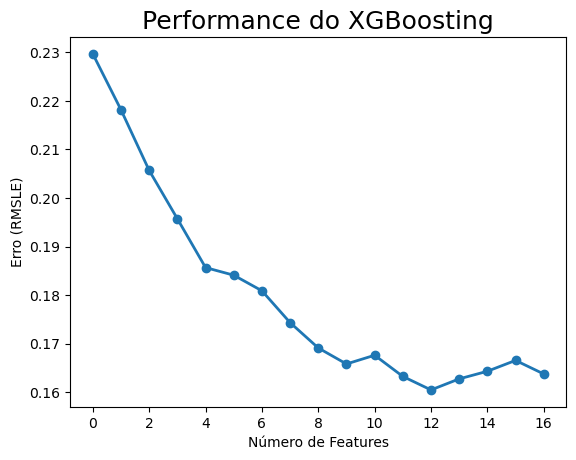

In [92]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(24, 16))
# plot
fig, ax = plt.subplots()

ax.plot(range(len(performance_XG)), performance_XG, linewidth=2.0, marker='o')

ax.set_title('Performance do XGBoosting', fontsize=18)
ax.set_xlabel('Número de Features', fontsize=10)
ax.set_ylabel('Erro (RMSLE)', fontsize=10)

plt.show()

In [93]:
# Valore ideal de features
performance_XG.index(min(performance_XG))

12

In [94]:
# Treinando com a quantidade ideal de features
XG = xgb.XGBRegressor(random_state=random_state)
XG.fit(X_train.loc[:,feature_importance_XG.index[:performance_XG.index(min(performance_XG))+1]], y_train)

y_pred_xg = XG.predict(X_test.loc[:,feature_importance_XG.index[:performance_XG.index(min(performance_XG))+1]])

RMSLE_XG = rmsle(y_test, y_pred_xg)
RMSLE_XG

0.16045571504881548

## Lasso

### Aqui é preciso normalizar as features para poder determinar suas importancias, devem estar na mesma escala
#### Utilizar o MinMaxEscaler para poder definir uma escala padrão

In [95]:
from sklearn.preprocessing import MinMaxScaler

# Criar o objeto scaler
scaler = MinMaxScaler(feature_range=(-1,1))

# Ajustar o scaler com os dados de treino
scaler.fit(base_train.drop('SalePrice', axis=1))

# Transformar os dados de treino
base_train_norm = base_train.copy()
base_train_norm[base_train.drop('SalePrice', axis=1).columns] = scaler.transform(base_train.drop('SalePrice', axis=1))

# Transformar os dados de teste
base_test_norm = base_test.copy()
base_test_norm[base_test.columns] = scaler.transform(base_test)

In [96]:
base_train.describe()

,OverallQual,GrLivArea,GarageArea/Car,YearBuilt,FullBath,GarageYrBlt,AreaTotalBsmt,YearRemodAdd,TotRmsAbvGrd,Fireplaces,OpenPorchSF,LotArea,MasVnrArea,LotFrontage,WoodDeckSF,HalfBath,BsmtFinSF1,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,976.719178,1971.267808,1.565068,1868.684247,2220.056164,1984.865753,6.517808,0.613014,46.660274,10516.828082,103.117123,69.863699,94.244521,0.382877,443.639726,180921.195890
std,1.382997,525.480383,709.723243,30.202904,0.550916,453.925967,787.333406,20.645407,1.625393,0.644666,66.256028,9981.264932,180.731373,22.027677,125.338794,0.502885,456.098091,79442.502883
min,1.000000,334.000000,0.000000,1872.000000,0.000000,-1.000000,334.000000,1950.000000,2.000000,0.000000,0.000000,1300.000000,0.000000,21.000000,0.000000,0.000000,0.000000,34900.000000
25%,5.000000,1129.500000,336.000000,1954.000000,1.000000,1958.000000,1696.000000,1967.000000,5.000000,0.000000,0.000000,7553.500000,0.000000,60.000000,0.000000,0.000000,0.000000,129975.000000
50%,6.000000,1464.000000,948.000000,1973.000000,2.000000,1977.000000,2064.000000,1994.000000,6.000000,1.000000,25.000000,9478.500000,0.000000,69.000000,0.000000,0.000000,383.500000,163000.000000
75%,7.000000,1776.750000,1152.000000,2000.000000,2.000000,2001.000000,2661.000000,2004.000000,7.000000,1.000000,68.000000,11601.500000,164.250000,79.000000,168.000000,1.000000,712.250000,214000.000000
max,10.000000,5642.000000,5424.000000,2010.000000,3.000000,2010.000000,10802.000000,2010.000000,14.000000,3.000000,547.000000,215245.000000,1600.000000,313.000000,857.000000,2.000000,5644.000000,755000.000000


In [97]:
base_train_norm.describe()

,OverallQual,GrLivArea,GarageArea/Car,YearBuilt,FullBath,GarageYrBlt,AreaTotalBsmt,YearRemodAdd,TotRmsAbvGrd,Fireplaces,OpenPorchSF,LotArea,MasVnrArea,LotFrontage,WoodDeckSF,HalfBath,BsmtFinSF1,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.133181,-0.554837,-0.639853,0.438664,0.043379,0.859457,-0.639653,0.162192,-0.247032,-0.591324,-0.829396,-0.913839,-0.871104,-0.665317,-0.780059,-0.617123,-0.842792,180921.195890
std,0.307333,0.197996,0.261697,0.437723,0.367277,0.451443,0.150427,0.688180,0.270899,0.429778,0.242252,0.093307,0.225914,0.150875,0.292506,0.502885,0.161622,79442.502883
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,34900.000000
25%,-0.111111,-0.700264,-0.876106,0.188406,-0.333333,0.948284,-0.739778,-0.433333,-0.500000,-1.000000,-1.000000,-0.941541,-1.000000,-0.732877,-1.000000,-1.000000,-1.000000,129975.000000
50%,0.111111,-0.574228,-0.650442,0.463768,0.333333,0.967181,-0.669469,0.466667,-0.333333,-0.333333,-0.908592,-0.923546,-1.000000,-0.671233,-1.000000,-1.000000,-0.864103,163000.000000
75%,0.333333,-0.456387,-0.575221,0.855072,0.333333,0.991049,-0.555407,0.800000,-0.166667,-0.333333,-0.751371,-0.903700,-0.794687,-0.602740,-0.607935,0.000000,-0.747608,214000.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,755000.000000


In [98]:
# Separar base normalizada em teste e treino
X_norm = base_train_norm.drop('SalePrice',axis=1)
X_train_norm , X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=0.33, random_state=42)

In [99]:
from sklearn.linear_model import Lasso

# Treinar o modelo Lasso
L = Lasso(alpha=0.1, random_state=random_state,max_iter=10000)
L.fit(X_train_norm, y_train_norm)

# Obter os coeficientes do modelo
feature_importance_L = pd.Series(L.coef_, index=X_norm.columns)
feature_importance_L = feature_importance_L.sort_values(ascending=False)
# Exibir a importância das features
print("Importância das Features:")
print(feature_importance_L)

Importância das Features:
OverallQual       85532.379059
GarageArea/Car    62680.745716
LotArea           57921.171001
GrLivArea         53374.568983
BsmtFinSF1        44477.281519
AreaTotalBsmt     26968.510845
TotRmsAbvGrd      23851.448607
Fireplaces        15075.113783
MasVnrArea        13138.644500
YearBuilt         12935.676718
WoodDeckSF        12247.608057
YearRemodAdd      11127.860989
HalfBath           2175.680823
FullBath          -1205.388660
OpenPorchSF       -1608.369340
GarageYrBlt       -2436.685945
LotFrontage      -14867.461262
dtype: float64


### Utilizar o modelo em ordem crescente de features com a maior importancia e observar melhor desempenho

In [100]:
performance_L = []

# Observar quantidade ideal de dimenssão neste modelo (maldição da dimensionalidade)

for i in range(1, len(X_train_norm.columns)+1):  
    X_train_selected = X_train_norm.loc[:,feature_importance_L.index[:i]]
    X_test_selected = X_test_norm.loc[:,feature_importance_L.index[:i]]
    
    L = Lasso(alpha=0.1, random_state=random_state,max_iter=100000)
    L.fit(X_train_selected, y_train_norm)
    
    y_pred_L = L.predict(X_test_selected)
    
    performance_L.append(rmsle(y_test_norm, y_pred_L))
    
performance_L

[0.35448175273027227,
 0.24852519278957771,
 0.24518299981500777,
 0.21773281033231298,
 0.2169629352245004,
 0.2122287414810461,
 0.2200840089704656,
 0.20421121836034745,
 0.2003200995055023,
 0.18808019398448464,
 0.18805235979144694,
 0.18611812998488722,
 0.18664918495251928,
 0.1865685559841775,
 0.18664779228343115,
 0.1839673744003477,
 0.18477906844767558]

### RMSLE em função da quantidade de features

<Figure size 2400x1600 with 0 Axes>

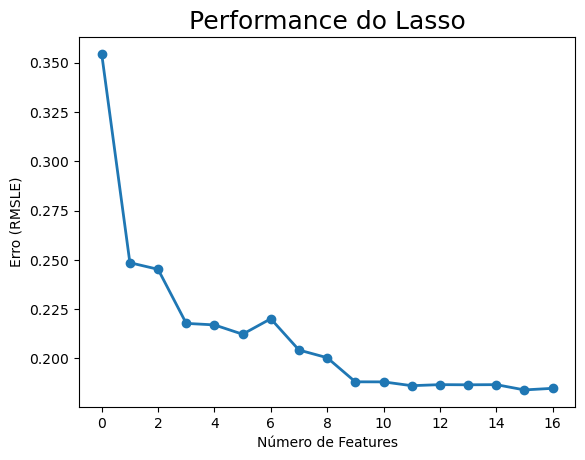

In [101]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(24, 16))
# plot
fig, ax = plt.subplots()

ax.plot(range(len(performance_L)), performance_L, linewidth=2.0, marker='o')

ax.set_title('Performance do Lasso', fontsize=18)
ax.set_xlabel('Número de Features', fontsize=10)
ax.set_ylabel('Erro (RMSLE)', fontsize=10)

plt.show()

In [102]:
# Valore ideal de features
performance_L.index(min(performance_L))

15

In [103]:
# Treinando com a quantidade ideal de features
L = Lasso(alpha=0.1, random_state=random_state,max_iter=100000)
L.fit(X_train_norm.loc[:,feature_importance_L.index[:performance_L.index(min(performance_L))+1]], y_train_norm)

y_pred_l = L.predict(X_test_norm.loc[:,feature_importance_L.index[:performance_L.index(min(performance_L))+1]])

RMSLE_L = rmsle(y_test, y_pred_l)
RMSLE_L

0.1839673744003477

- **Resumo do melhor desempenho de cada modelo:**    
    - Comparando com os resultados do Checkpoint 1, pode ser notado uma piora
    - Podemos considerar que a seleção de features tem melhor desempenho se deixar-mos por conta do modelo
    - Desconsiderar as features menos correlatas não teve um bom resultado aparente

In [118]:
# Importando o erro médio absoluto
print("Melhores RMSLE")
print("Gradiente Boosting: {}".format(RMSLE_GB))
print("XGBoosting: {}".format(RMSLE_XG))
print("Lasso: {}".format(RMSLE_L))

Melhores RMSLE
Gradiente Boosting: 0.15585132425393566
XGBoosting: 0.16045571504881548
Lasso: 0.1839673744003477


- **Podemos plotar visualmente a relação do y_test com as previsões feitas**
    - Predições perfeitas seriam se or pontos estivessem exatamente sobre a reta (y=x)
    - O Gráfico permite observar também a faixa de preços em que o modelo mais acerta e mais erra
    - Preços acima de 500.000 apresentaram dificuldade de predição em todos modelos
    - Para isso vamos utilizar o matplotlib
        - https://matplotlib.org/

In [105]:
# Importando o matplotlib
import matplotlib.pyplot as plt

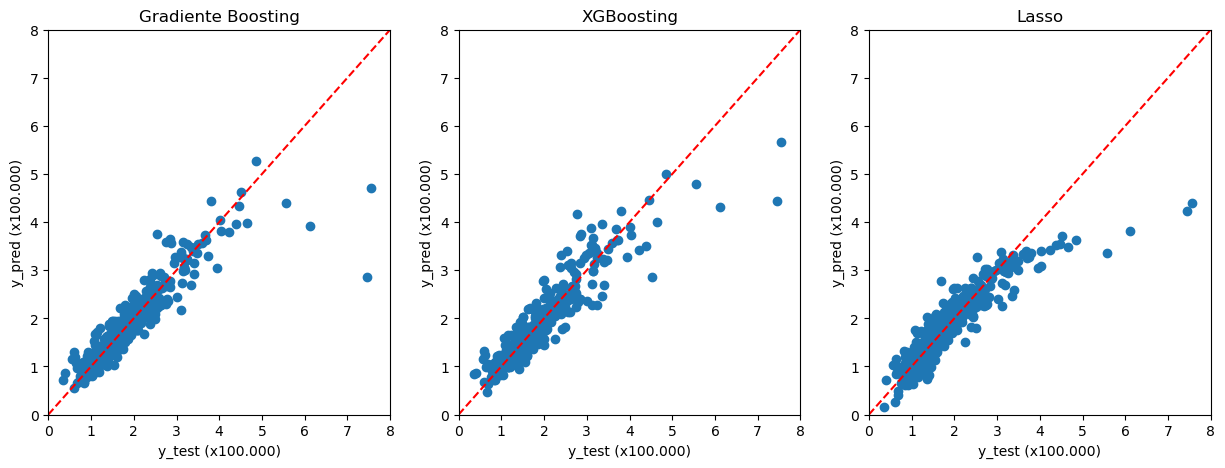

In [106]:
# Criando esse gráfico
fig, ax = plt.subplots(ncols=3,figsize=(15,5))

ax[0].scatter(y_test/100000, y_pred_gb/100000)
ax[0].plot([0,8],[0,8],'--r')
ax[1].scatter(y_test/100000, y_pred_xg/100000)
ax[1].plot([0,8],[0,8],'--r')
ax[2].scatter(y_test/100000, y_pred_l/100000)
ax[2].plot([0,8],[0,8],'--r')

ax[0].set(xlim=(0, 8),ylim=(0, 8))
ax[0].set_xlabel('y_test (x100.000)')
ax[0].set_ylabel('y_pred (x100.000)')
ax[0].set_title('Gradiente Boosting')
ax[1].set(xlim=(0, 8),ylim=(0, 8))
ax[1].set_xlabel('y_test (x100.000)')
ax[1].set_ylabel('y_pred (x100.000)')
ax[1].set_title('XGBoosting')
ax[2].set(xlim=(0, 8),ylim=(0, 8))
ax[2].set_xlabel('y_test (x100.000)')
ax[2].set_ylabel('y_pred (x100.000)')
ax[2].set_title('Lasso')

plt.show()

## Fazendo a previsão para a base de teste da competição
- Considerando o melhor modelo para realizar a predição
- Realizar seleção de features de acordo com o obtido para o modelo em questão

In [107]:
colunas_gb = (X_test.loc[:,feature_importance_GB.index[:performance_GB.index(min(performance_GB))+1]]).columns

In [108]:
# Visualizando a base com todas features
base_test.head()

,OverallQual,GrLivArea,GarageArea/Car,YearBuilt,FullBath,GarageYrBlt,AreaTotalBsmt,YearRemodAdd,TotRmsAbvGrd,Fireplaces,OpenPorchSF,LotArea,MasVnrArea,LotFrontage,WoodDeckSF,HalfBath,BsmtFinSF1
0,5,896,730.0,1961,1,1961.0,1778.0,1961,5,0,0,11622,0.0,80.0,140,0,468.0
1,6,1329,312.0,1958,1,1958.0,2658.0,1958,6,0,36,14267,108.0,81.0,393,1,923.0
2,5,1629,964.0,1997,2,1997.0,1856.0,1998,6,1,34,13830,0.0,74.0,212,1,791.0
3,6,1604,940.0,1998,2,1998.0,1852.0,1998,7,1,36,9978,20.0,78.0,360,1,602.0
4,8,1280,1012.0,1992,2,1992.0,2560.0,1992,5,0,82,5005,0.0,43.0,0,0,263.0


In [109]:
# Utilizar as mesmas colunas na base de teste
base_test = base_test[colunas_gb]

In [110]:
# Verificando a base restante
base_test.head()

,OverallQual,GrLivArea,AreaTotalBsmt,GarageArea/Car,BsmtFinSF1,YearBuilt,LotArea,YearRemodAdd
0,5,896,1778.0,730.0,468.0,1961,11622,1961
1,6,1329,2658.0,312.0,923.0,1958,14267,1958
2,5,1629,1856.0,964.0,791.0,1997,13830,1998
3,6,1604,1852.0,940.0,602.0,1998,9978,1998
4,8,1280,2560.0,1012.0,263.0,1992,5005,1992


In [111]:
# Verificar valores nulos
base_test.isnull().sum()

OverallQual       0
GrLivArea         0
AreaTotalBsmt     0
GarageArea/Car    0
BsmtFinSF1        0
YearBuilt         0
LotArea           0
YearRemodAdd      0
dtype: int64

- **Agora podemos usar nosso modelo e ajustar os dados para usarmos no Kaggle**

In [112]:
# Vamos usar a Regressão Linear para fazer a previsão
y_pred = GB.predict(base_test)

In [113]:
# Podemos adicionar essa coluna de previsão na nossa base
base_test['SalePrice'] = y_pred

In [114]:
test = pd.read_csv("test.csv") 
base_test['Id'] =test.Id

In [115]:
# E extrair somente o Id e o SalePrice
base_kaggle = base_test[['Id','SalePrice']]
base_kaggle.head(3)

,Id,SalePrice
0,1461,126952.358340
1,1462,155221.382533
2,1463,179803.035977


In [119]:
# Podemos então exportar essa base
base_kaggle.to_csv('resultado2.csv',index=False)